# Imports

In [11]:
!pip install plotly==5.14.1
!pip install "jupyterlab>=3" "ipywidgets>=7.6"
!pip install jupyter-dash
!pip install -U kaleido

In [12]:
!pip install numpy
!pip install pandas
!pip install openpyxl
!pip install seaborn
!pip install matplotlib
!pip install -U scikit-learn
!pip install shap
!pip install xgboost

In [1]:
import numpy as np
import pandas as pd
import openpyxl as xl
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 
import shap

/Users/alexglushko/ProgProjects/ChemML/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

In [2]:
excel_path = r"../../static/mock/titanium sols.xlsx"
artifacts_path = r"../../static/mock/soles_artifacts/third_dataset/"

In [3]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df = tables_dict["Table3"]['dataframe']
df = df.fillna(value=0)


worksheet name: Sheet1
tables in worksheet: 0

worksheet name: Experiment_data
tables in worksheet: 1
table name: Table1

worksheet name: Experiment_data_2
tables in worksheet: 1
table name: Table2

worksheet name: Experiment_data_3
tables in worksheet: 1
table name: Table3


In [4]:
df.shape

(64, 8)

In [5]:
df.head()

,Composition mixtures,"t, °С","t, min","с(acid), M","с(Ti4+), M","d, nm","Contents, %","Stability of sols, days"
0,H2O + HNO3 + TiIPO + ButOH,45,60,4.0,0.50,618.500,100.0,16.0
1,H2O + HNO3 + TiIPO + ButOH,80,10,4.0,0.50,978.100,100.0,16.0
2,H2O + HNO3 + TiIPO + ButOH,45,20,4.0,0.50,2.000,100.0,90.0
3,H2O + HNO3 + TiIPO + ButOH,45,20,4.0,0.47,2.628,100.0,60.0
4,H2O + HNO3 + TiIPO + IPOОН,50,20,4.0,0.20,1712.000,100.0,16.0


In [6]:
df.drop('Composition mixtures', axis=1).astype('float').describe().T

,count,mean,std,min,25%,50%,75%,max
"t, °С",64.0,59.828125,21.207632,20.00,45.00000,60.00,80.000,93.00
"t, min",64.0,35.125000,31.555192,8.00,11.75000,20.00,60.000,130.00
"с(acid), M",64.0,1.174375,1.571372,0.10,0.10000,0.28,2.095,4.00
"с(Ti4+), M",64.0,0.392813,0.191348,0.14,0.17000,0.41,0.600,0.62
"d, nm",64.0,790.852641,957.557550,0.70,2.14675,4.43,2000.000,3096.00
"Contents, %",64.0,96.706250,15.103987,0.50,100.00000,100.00,100.000,100.00
"Stability of sols, days",64.0,24.859375,26.957561,0.00,2.00000,13.00,40.000,90.00


In [7]:
df.dtypes

Composition mixtures        object
t, °С                        int64
t, min                       int64
с(acid), M                 float64
с(Ti4+), M                 float64
d, nm                      float64
Contents, %                float64
Stability of sols, days    float64
dtype: object

In [8]:
composition_mixtures_dict = {
    'H2O + HNO3 + TiIPO + ButOH': 1,
    'H2O + HNO3 + TiIPO + IPOОН': 2,
    'H2O + HNO3 + ТiBut + ButOH': 3,
    'H2O + TiOSO₄´xH2SO4´yH2O': 4,
}
df = df.replace(composition_mixtures_dict)

/var/folders/03/8g_v72pd32vfbhfq91cfy1780000gn/T/ipykernel_16840/2365379211.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(composition_mixtures_dict)


In [9]:
df = df.rename(columns={'t, min': r'$\tau$, min'})
X = df.drop(['Contents, %', 'd, nm', 'Stability of sols, days'], axis=1)
y_days = df['Stability of sols, days']
y_d = df['d, nm']
y_content = df['Contents, %']

In [10]:
X

,Composition mixtures,"t, °С","$\tau$, min","с(acid), M","с(Ti4+), M"
0,1,45,60,4.0,0.50
1,1,80,10,4.0,0.50
2,1,45,20,4.0,0.50
3,1,45,20,4.0,0.47
4,2,50,20,4.0,0.20
...,...,...,...,...,...
59,4,70,12,0.1,0.62
60,4,70,12,0.1,0.59
61,4,70,12,0.1,0.55
62,4,70,12,0.1,0.52


# Random forest feature importance prediction

## Useful functions

In [11]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


In [12]:
def draw_importance(importances, model_name, columns=X.columns):
    features = {}
    color1 = "#2D466D"
    color2 = "#A2B0C5"
    for i, feature in enumerate(columns):
        features[f"f{i+1}"] = feature

    indices = np.argsort(importances)[::-1]
    num_to_plot = len(columns)
    feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

    print("Feature ranking:")
    for f in range(num_to_plot):
        print(
            "%d. %s %f "
            % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
        )
    plt.figure(figsize=(20, 10))
    bars = plt.bar(
        range(num_to_plot),
        importances[indices[:num_to_plot]],
        color=get_color_gradient(color1, color2, num_to_plot),
        align="center",
    )
    ticks = plt.xticks(range(num_to_plot), feature_indices, fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlim([-1, num_to_plot])
    plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices], fontsize="24");
    plt.title(f"Feature importance in {model_name}", fontsize=22)
    plt.savefig(f'{artifacts_path}{model_name}.eps', format='eps', dpi=600, bbox_inches='tight', transparent="True", pad_inches=0)
    

In [13]:
def learn_random_forest(X, y, name):
    parameters = {
        'n_estimators': range(100, 500, 100),
        'max_depth': [None] + list(range(3, 11, 2))}

    model = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_random_forest = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_random_forest.feature_importances_, f"Random forest {name}")
    return best_random_forest

In [14]:
def learn_gradient_boosting(X, y, name):
    parameters = {
        'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
        'n_estimators': [4, 8, 16, 32, 64, 128],
        'max_depth': range(1, 18, 2)}

    model = GradientBoostingRegressor(random_state=42)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_gradient_boost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_gradient_boost.feature_importances_, f"Gradient boost {name}")
    return best_gradient_boost

In [15]:
def learn_xgboost(X, y, name):
    parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5,],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_xgboost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    draw_importance(best_xgboost.feature_importances_, f"XGboost {name}")
    return best_xgboost

## Learning

-18.039437845361554
{'max_depth': 3, 'n_estimators': 400}
Feature ranking:
1. с(Ti4+), M 0.412926 
2. $\tau$, min 0.293165 
3. с(acid), M 0.136039 
4. t, °С 0.135866 
5. Composition mixtures 0.022005 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


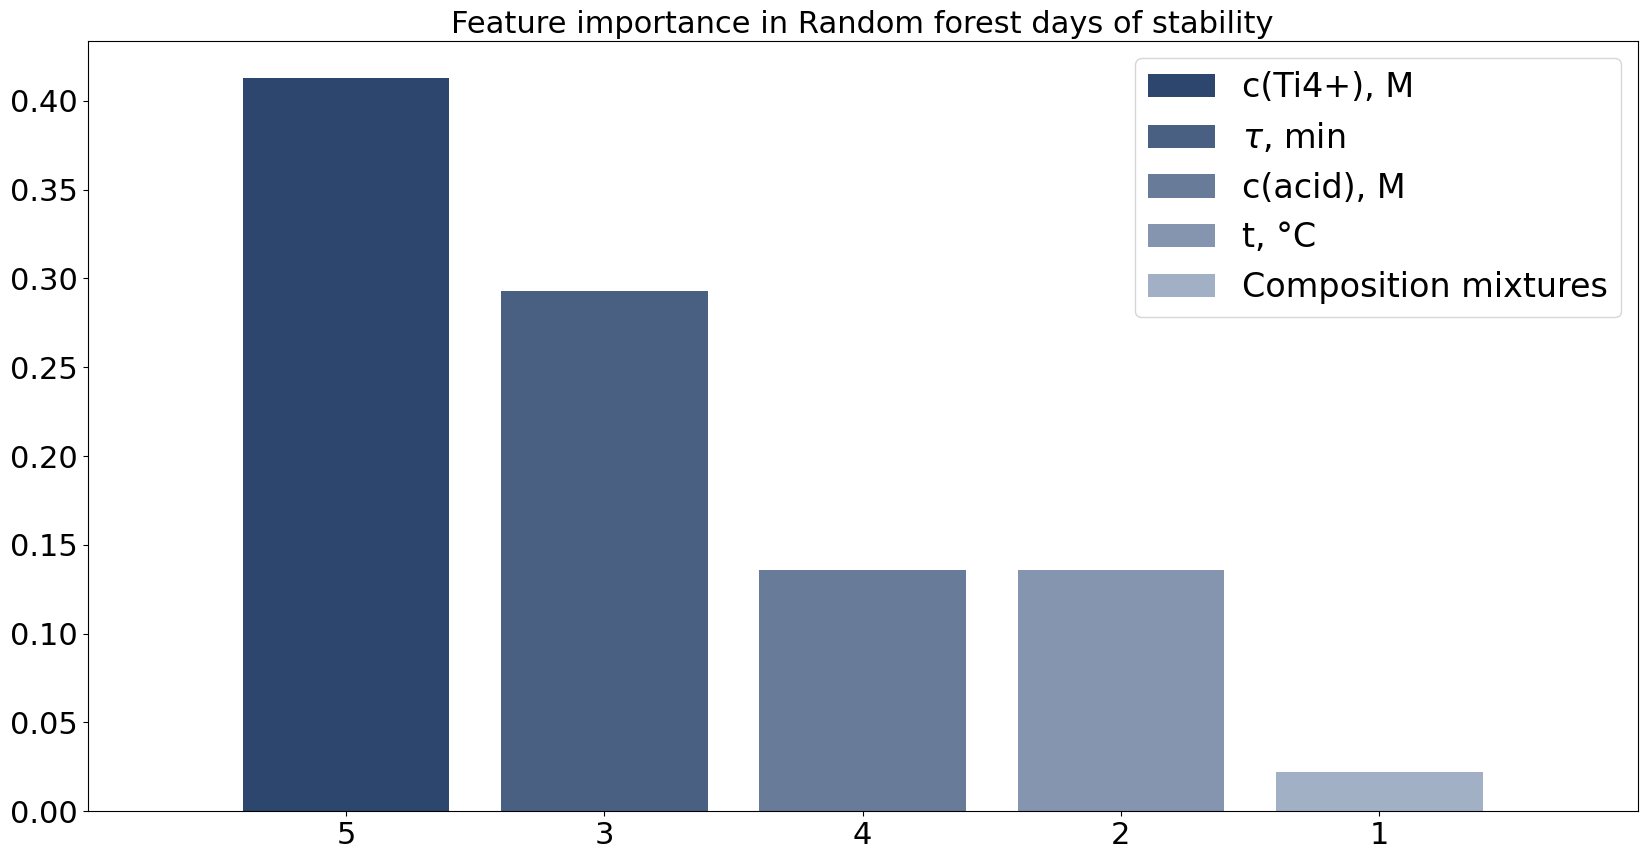

In [16]:
days_rf = learn_random_forest(X, y_days, "days of stability")

-17.800596512873636
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 128}
Feature ranking:
1. с(Ti4+), M 0.346044 
2. $\tau$, min 0.334205 
3. с(acid), M 0.254824 
4. t, °С 0.062010 
5. Composition mixtures 0.002917 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


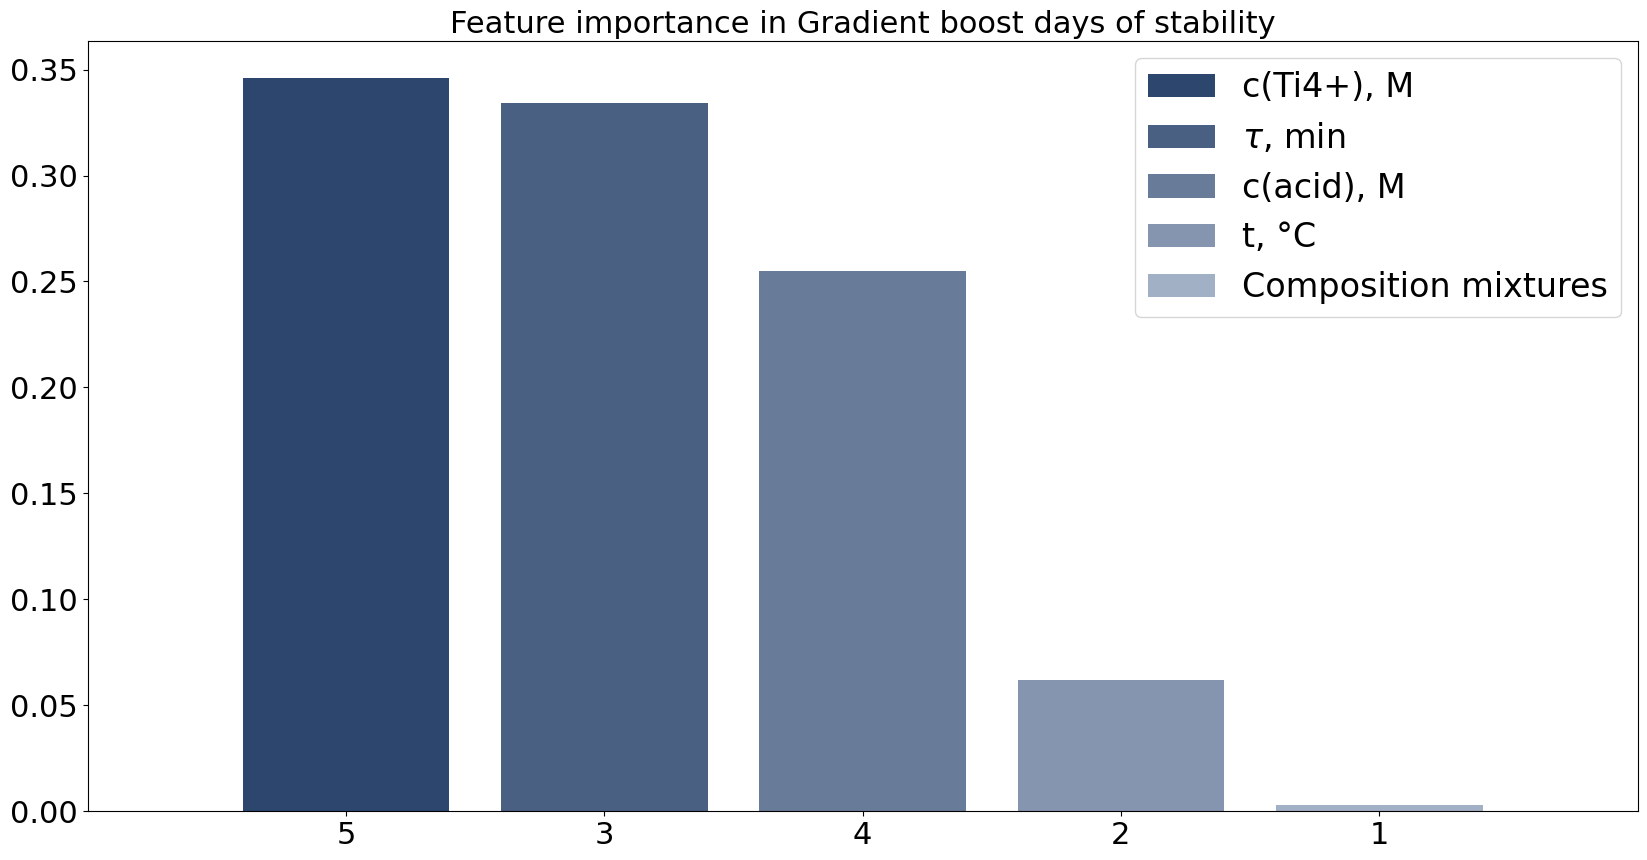

In [17]:
days_grad = learn_gradient_boosting(X, y_days, "days of stability")

-15.522651418050131
{'colsample_bytree': 1.0, 'gamma': 2.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 1.0}
Feature ranking:
1. с(acid), M 0.404673 
2. с(Ti4+), M 0.249674 
3. $\tau$, min 0.191347 
4. t, °С 0.128867 
5. Composition mixtures 0.025439 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


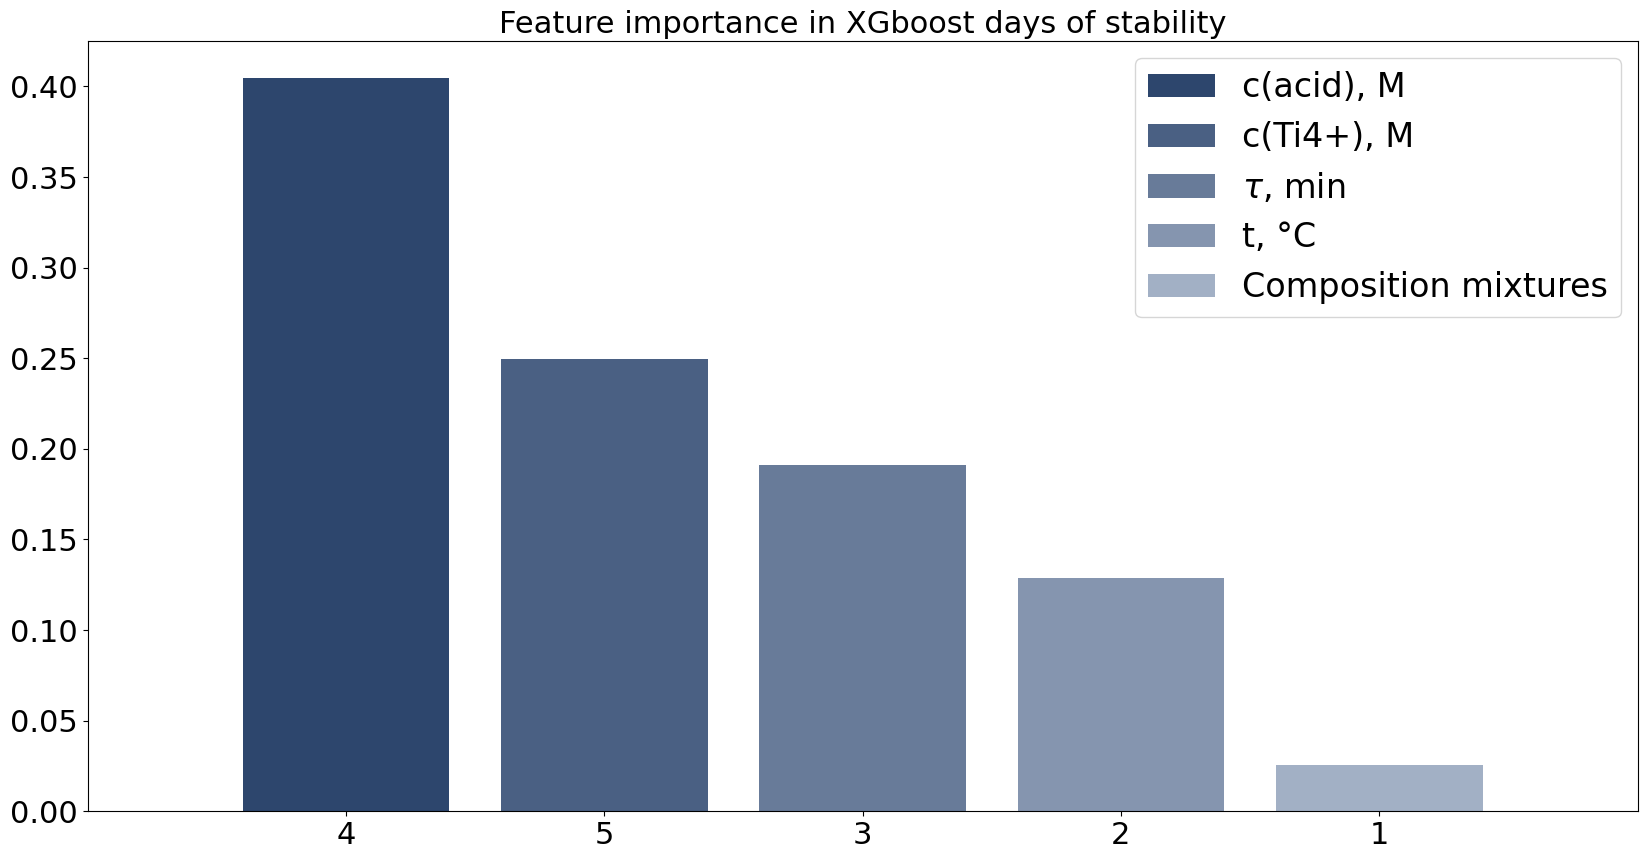

In [18]:
days_xgboost = learn_xgboost(X, y_days, "days of stability")

-661.8052523178422
{'max_depth': 5, 'n_estimators': 100}
Feature ranking:
1. с(Ti4+), M 0.674041 
2. $\tau$, min 0.110658 
3. с(acid), M 0.085458 
4. t, °С 0.082435 
5. Composition mixtures 0.047408 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


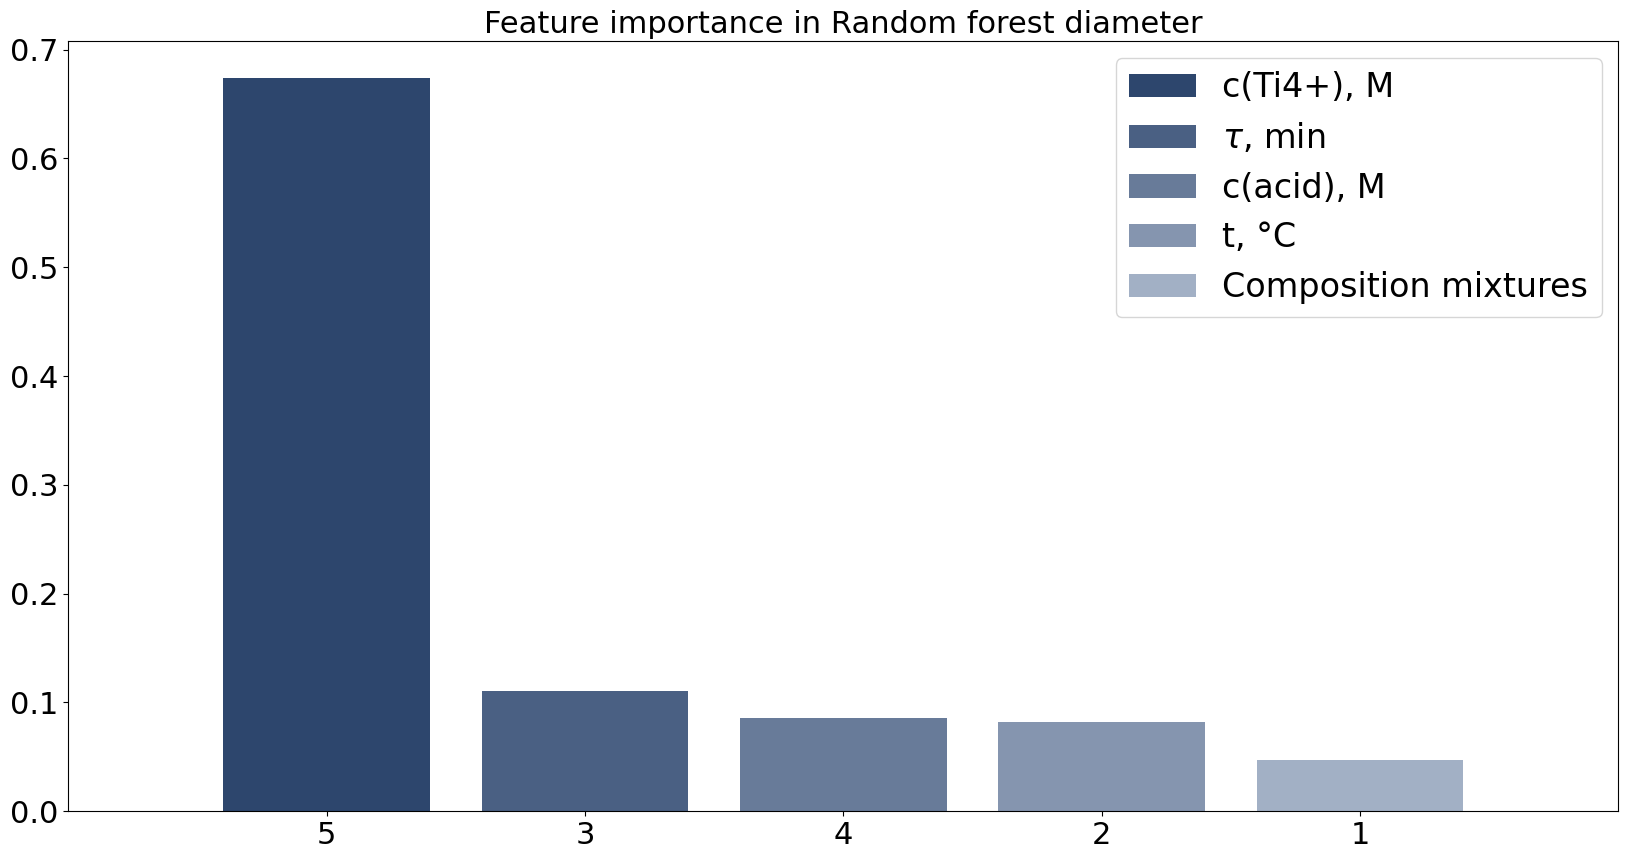

In [19]:
d_rf = learn_random_forest(X, y_d, "diameter")

-543.5611157729148
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 4}
Feature ranking:
1. с(Ti4+), M 0.871698 
2. с(acid), M 0.079860 
3. $\tau$, min 0.048442 
4. t, °С 0.000000 
5. Composition mixtures 0.000000 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


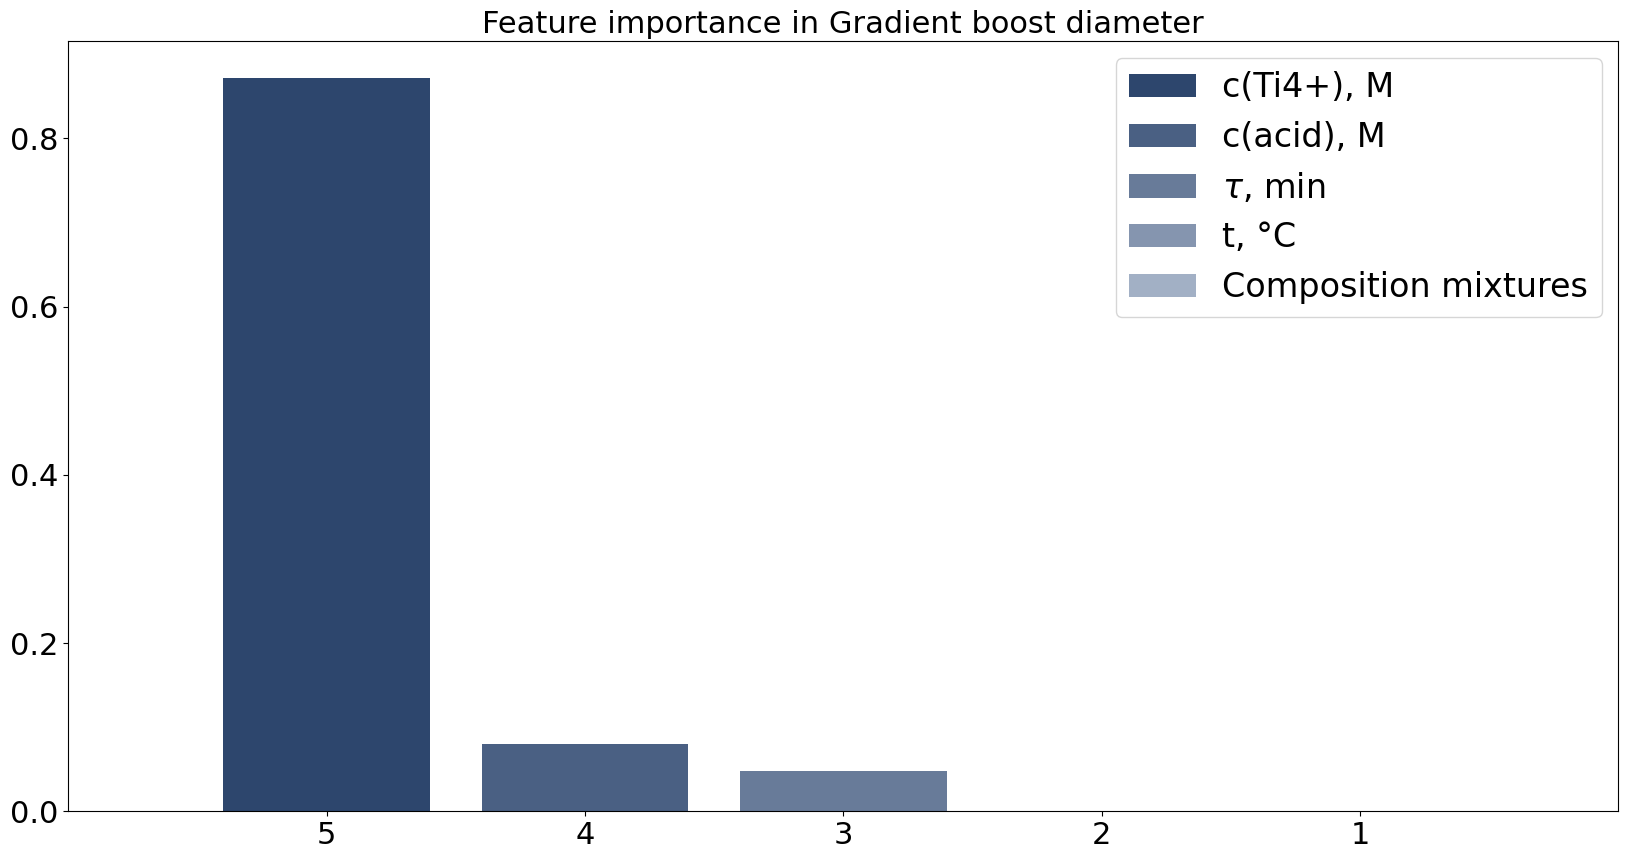

In [20]:
d_grad = learn_gradient_boosting(X, y_d, "diameter")

-484.1234260223193
{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}
Feature ranking:
1. с(Ti4+), M 0.440616 
2. с(acid), M 0.236519 
3. Composition mixtures 0.159645 
4. $\tau$, min 0.088988 
5. t, °С 0.074232 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


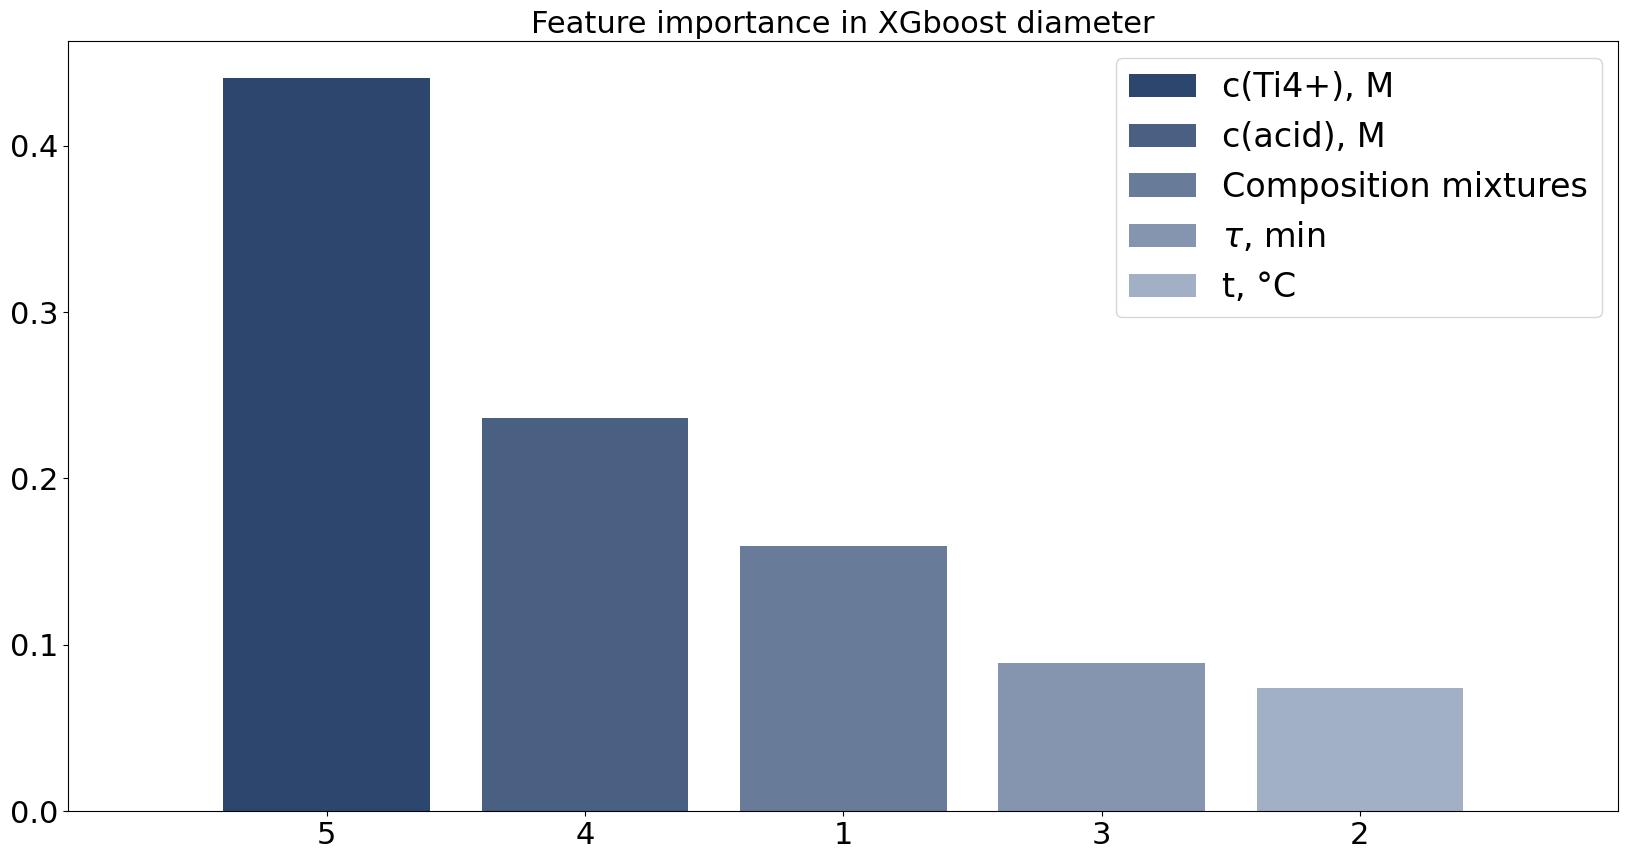

In [21]:
d_xgboost = learn_xgboost(X, y_d, "diameter")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-8.14104753769669
{'max_depth': 5, 'n_estimators': 400}
Feature ranking:
1. $\tau$, min 0.615932 
2. Composition mixtures 0.164218 
3. с(acid), M 0.084814 
4. с(Ti4+), M 0.070477 
5. t, °С 0.064560 


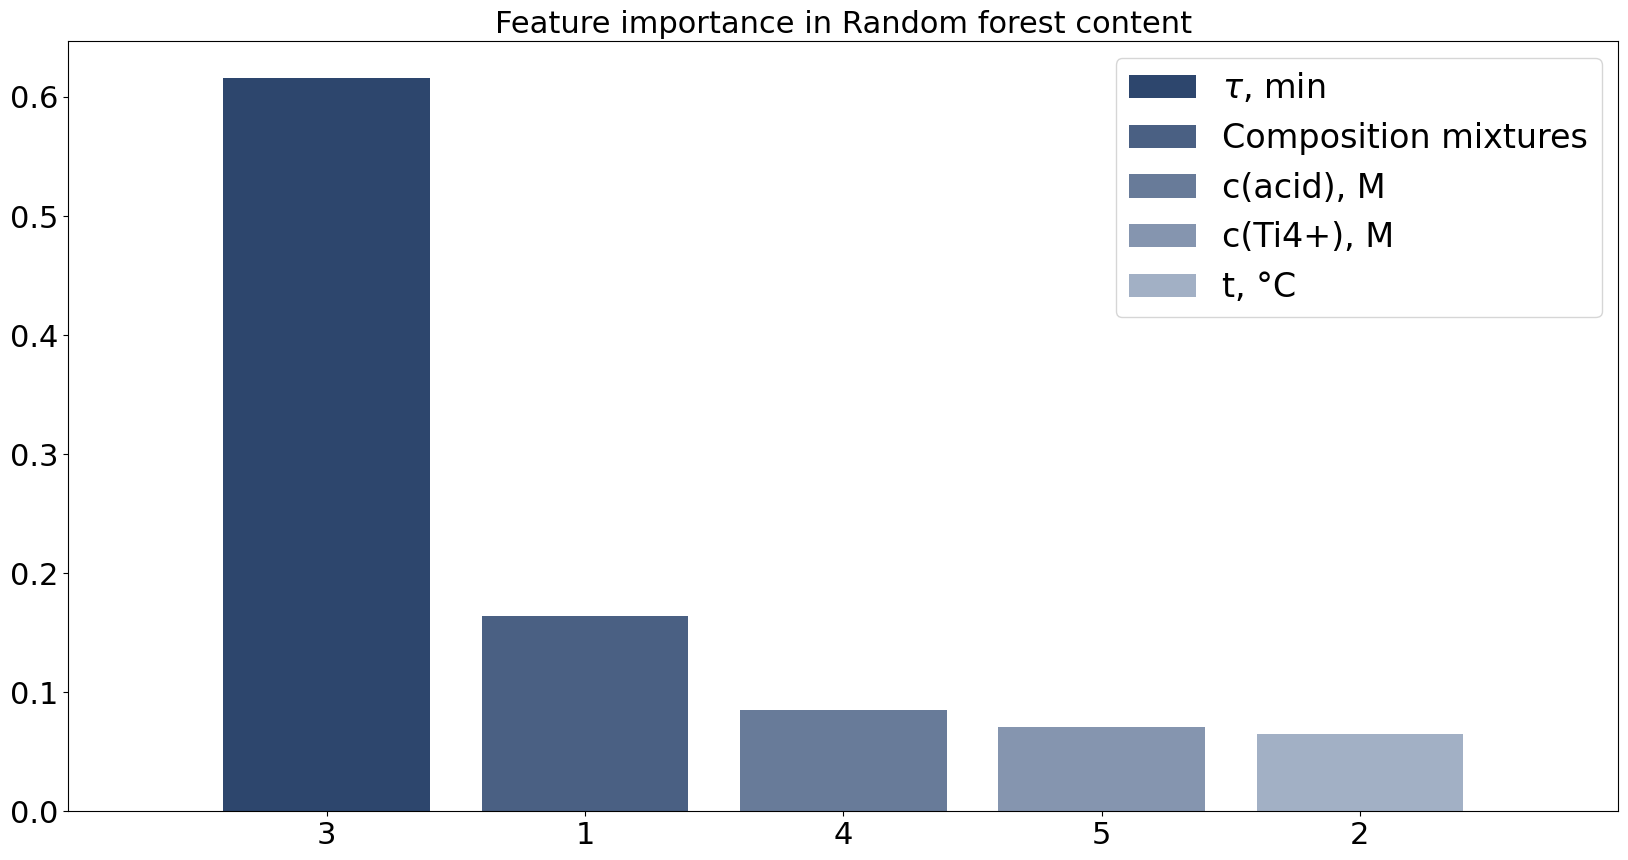

In [22]:
content_rf = learn_random_forest(X, y_content, "content")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


-6.0126879249035525
{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 4}
Feature ranking:
1. $\tau$, min 1.000000 
2. с(Ti4+), M 0.000000 
3. с(acid), M 0.000000 
4. t, °С 0.000000 
5. Composition mixtures 0.000000 


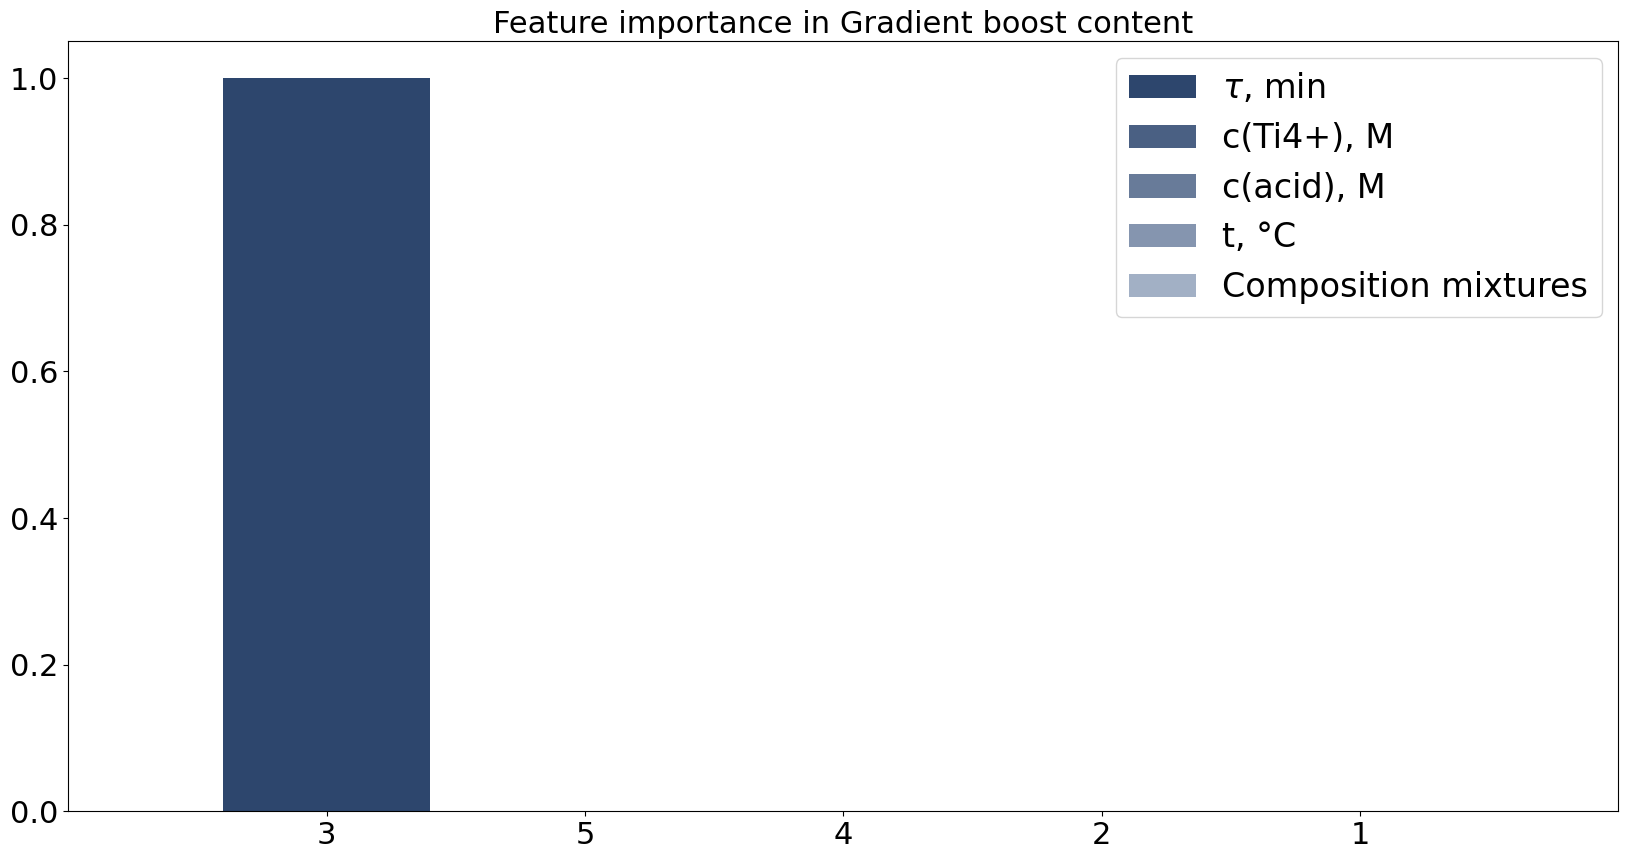

In [23]:
content_gb = learn_gradient_boosting(X, y_content, "content")

-5.56008298042493
{'colsample_bytree': 0.6, 'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}
Feature ranking:
1. $\tau$, min 0.289938 
2. с(Ti4+), M 0.276080 
3. Composition mixtures 0.161477 
4. t, °С 0.138827 
5. с(acid), M 0.133677 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


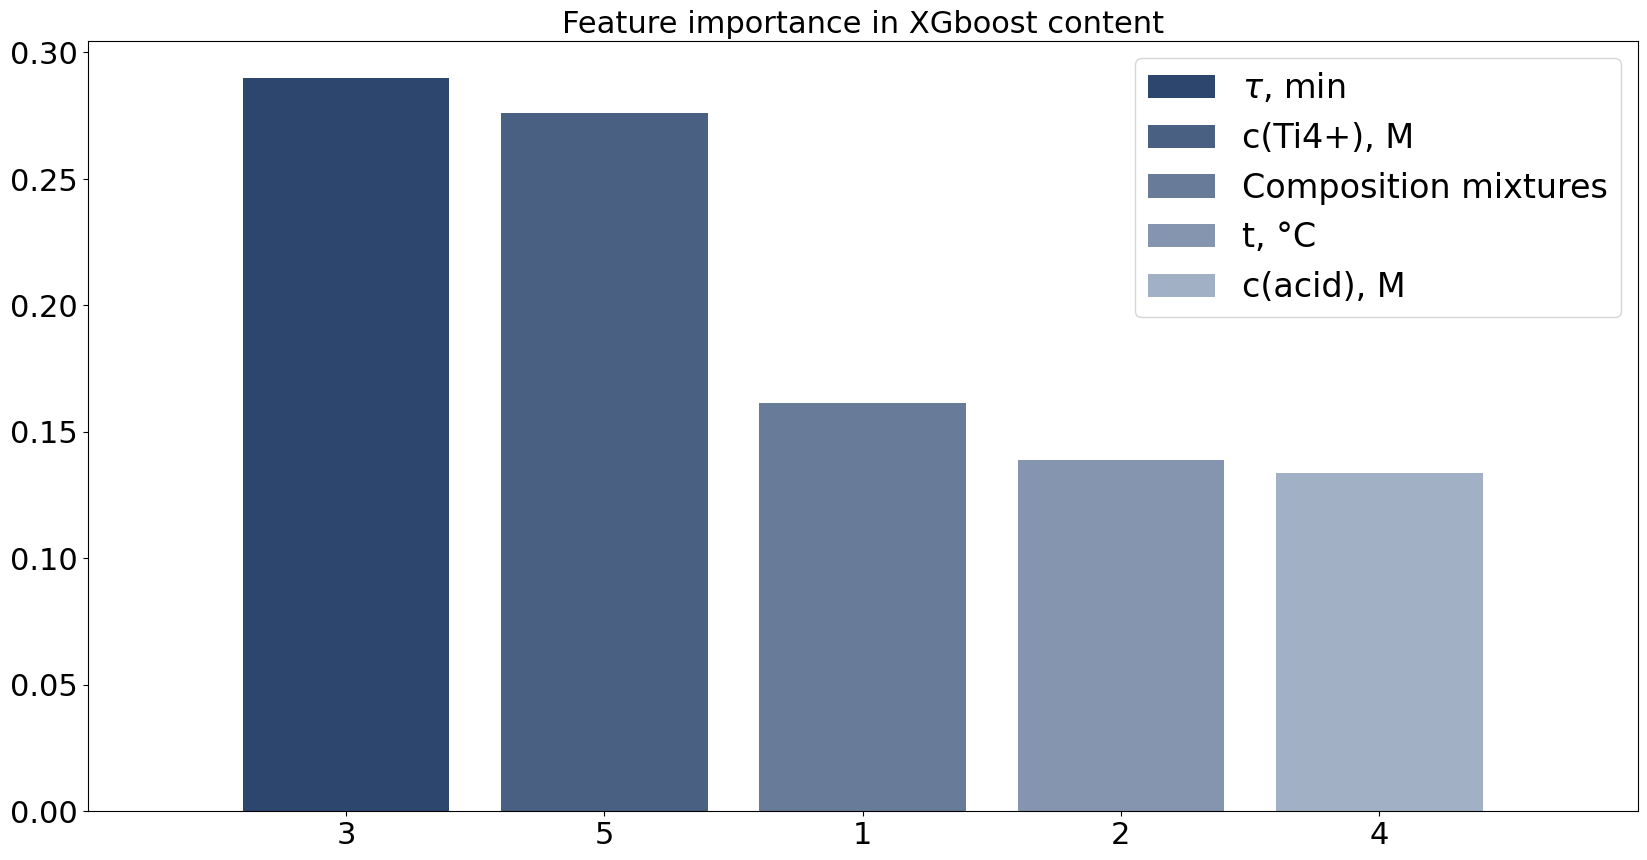

In [24]:
content_xgb = learn_xgboost(X, y_content, "content")

## Shap

In [71]:
def explain(model, X=X, name="model", is_save=False, color_bar=False):
    X = X.rename(columns={'Composition mixtures': 'Com. mix.'})
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, plot_size=[10, 6], s=26, show=False, color_bar=color_bar)
    if is_save:
        plt.savefig(f'{artifacts_path}{name} shap.png', bbox_inches='tight')

### Days of stability

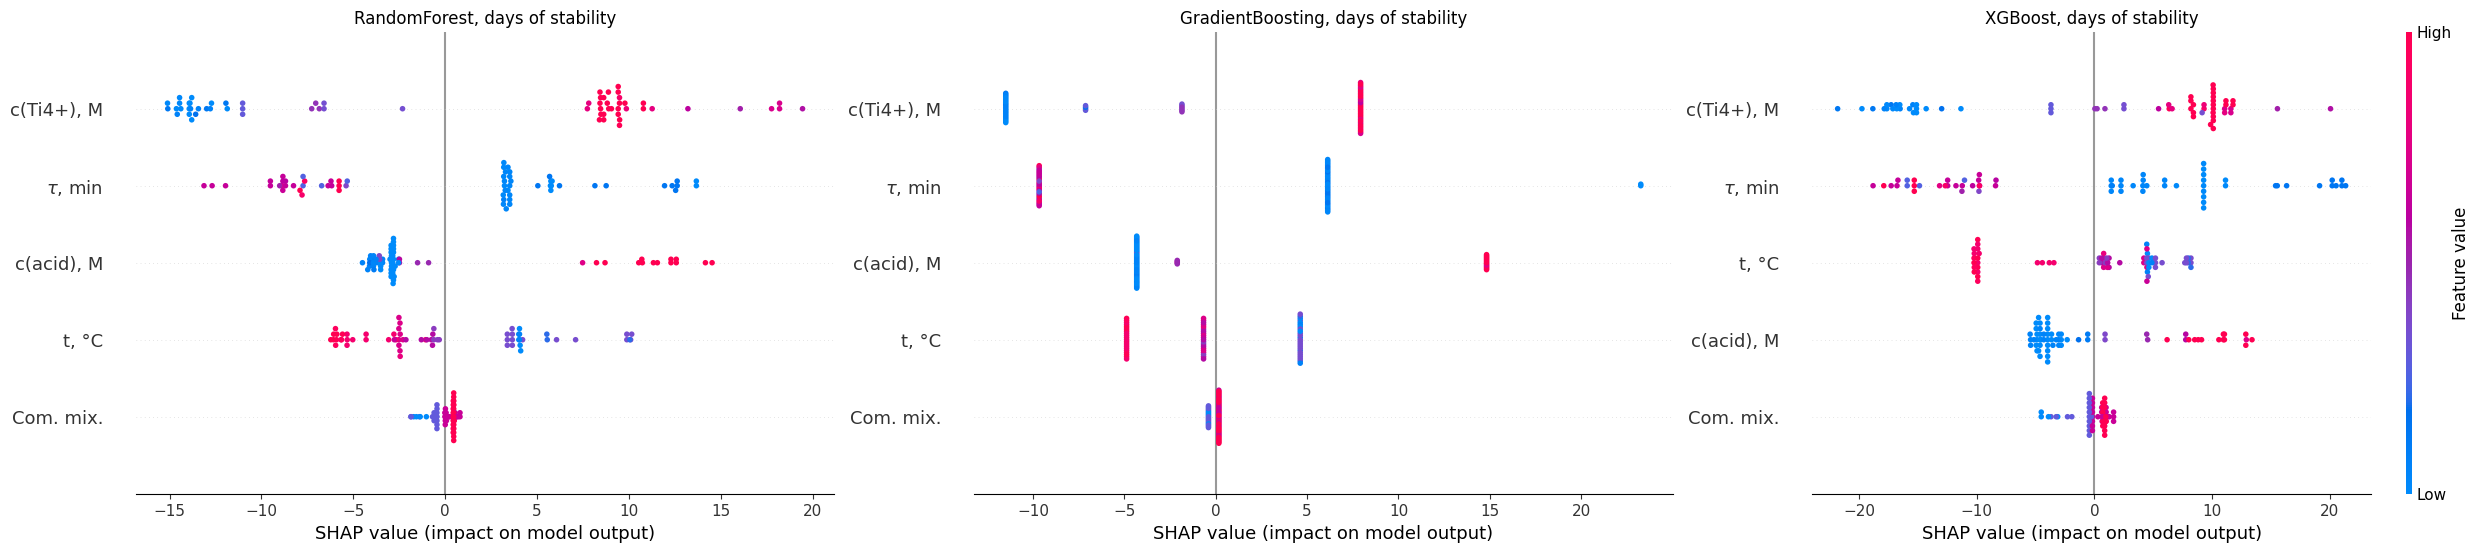

In [93]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title("RandomForest, days of stability")
explain(days_rf, name="RandomForest, days of stability")
plt.subplot(1, 3, 2)
plt.title("GradientBoosting, days of stability")
explain(days_grad, name="GradientBoosting, days of stability")
plt.subplot(1, 3, 3)
plt.title("XGBoost, days of stability")
explain(days_xgboost, name="XGBoost, days of stability", color_bar=True)
plt.subplots_adjust(right=2)
plt.subplots_adjust( 
    right=2.5
)
plt.savefig(f'{artifacts_path}Stability shap.png', bbox_inches='tight')

### Diameter of zole

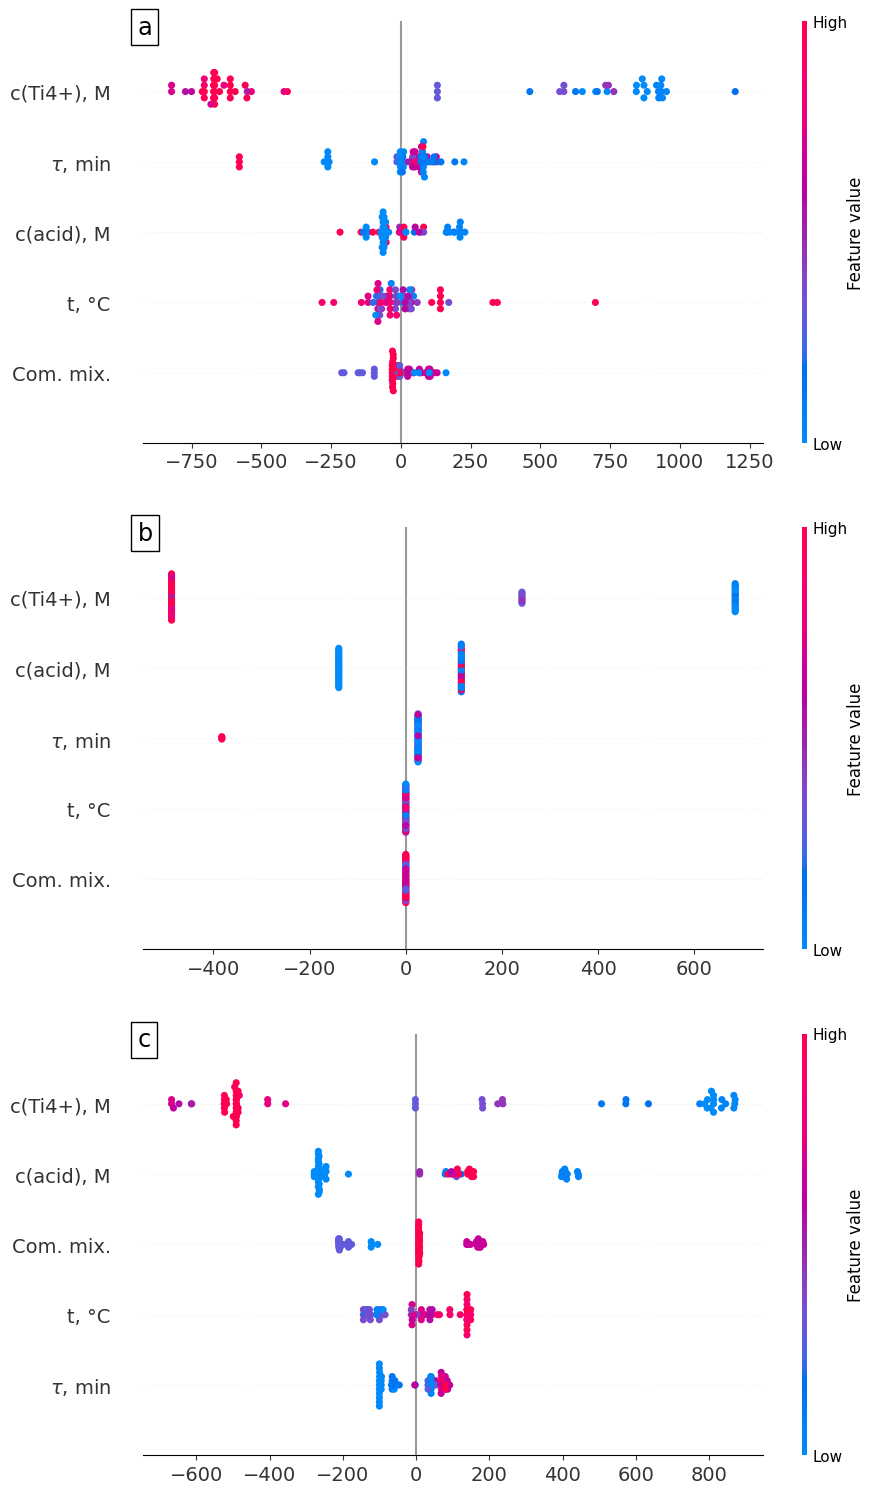

In [73]:
from matplotlib.offsetbox import AnchoredText

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
y = 0.02
x = 1.03
# plt.title("a", y=y, x=x, fontsize=18)
txt = AnchoredText("a", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(d_rf, name="RandomForest, diameter", color_bar=True)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.subplot(3, 1, 2)
# plt.title("b", y=y, x=x, fontsize=18)
txt = AnchoredText("b", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(d_grad, name="GradientBoosting, diameter", color_bar=True)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.subplot(3, 1, 3)
# plt.title("c", y=y, x=x, fontsize=18)
txt = AnchoredText("c", loc="upper left", pad=0.25, borderpad=-0.5, prop=dict(fontsize="xx-large"))
plt.gca().add_artist(txt)
explain(d_xgboost, name="XGBoost, diameter", color_bar=True)
plt.subplots_adjust( 
    top=2.5
)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.tick_params(axis='both', labelsize=14)

plt.savefig(f'{artifacts_path}Diameter shap.png', bbox_inches='tight')

### Content

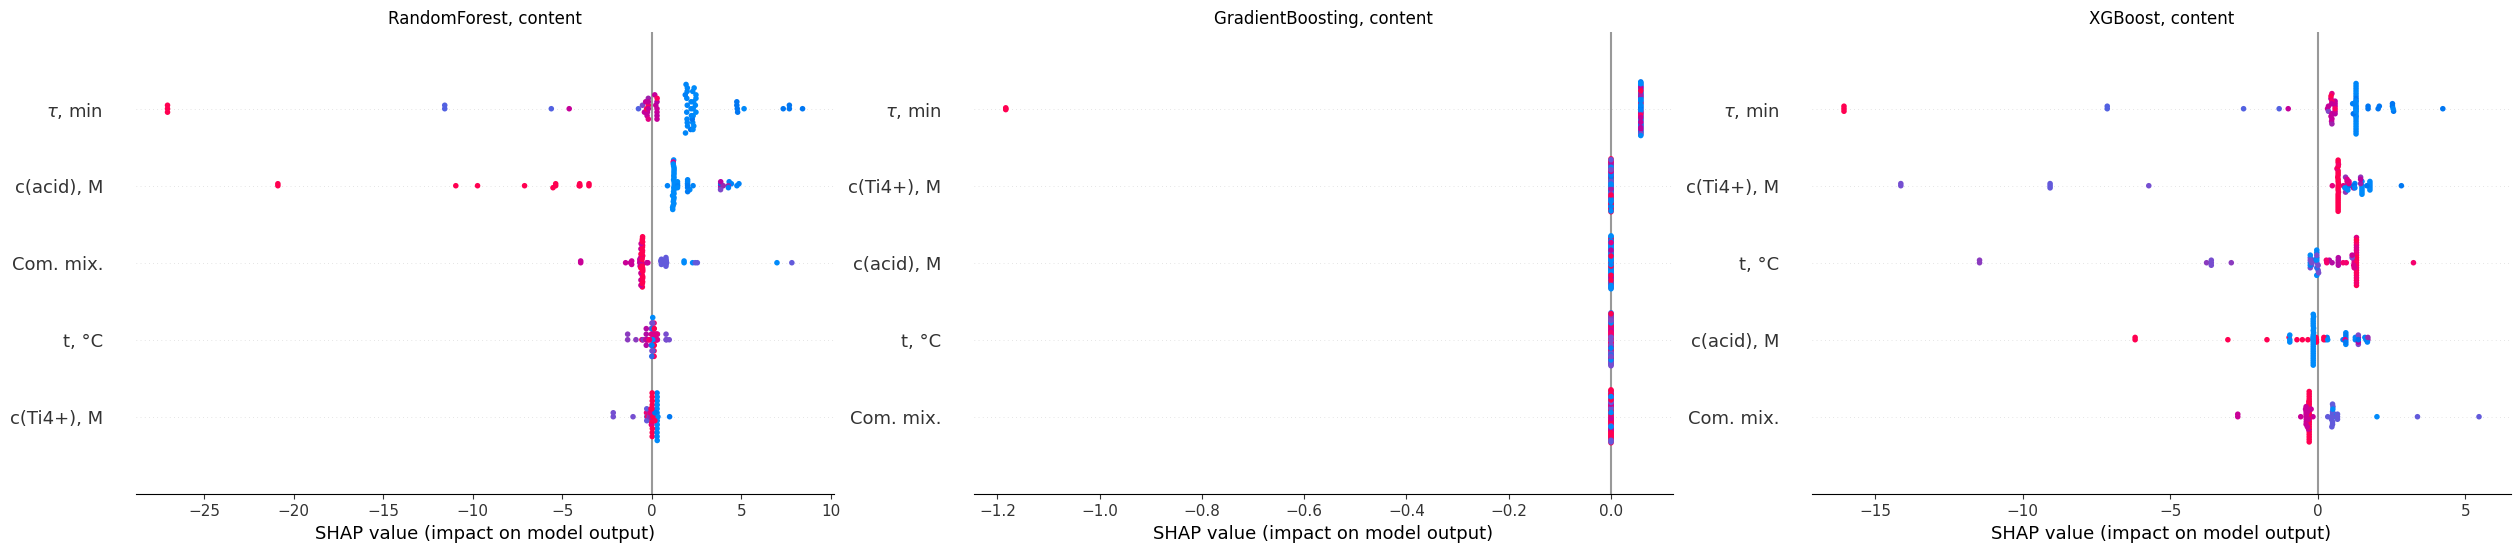

In [95]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title("RandomForest, content")
explain(content_rf, name="RandomForest, content")
plt.subplot(1, 3, 2)
plt.title("GradientBoosting, content")
explain(content_gb, name="GradientBoosting, content")
plt.subplot(1, 3, 3)
plt.title("XGBoost, content")
explain(content_xgb, name="XGBoost, content")
plt.subplots_adjust(
    right=2.5, 
)

plt.savefig(f'{artifacts_path}Content shap.png', bbox_inches='tight')